https://www.kaggle.com/carlosaguayo/deep-learning-for-text-classification/data

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets.base import get_data_home
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1qx_40VFqRgy8ZLDVfu40Oh-9Q4wpAOdx'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1qx_40VFqRgy8ZLDVfu40Oh-9Q4wpAOdx


In [0]:
#Carregando a base de dados
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Opinosis-Parsed.csv')  
df3 = pd.read_csv('Opinosis-Parsed.csv')

In [0]:
print(len(df3.data))

6457


In [0]:
#Definindo constantes
max_length = 100
num_labels = 51
vocab_size = 9000
batch_size = [100]
epochs = [10]

# Pré-processamento do Texto

É necessário tokenizar o texto antes de podermos alimentá-lo em uma rede neural. Esse processo de tokenização também removerá alguns dos recursos do texto original, como todas as pontuações ou palavras menos comuns.

In [0]:
# Extract text
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(df3.data)
sequences = tokenizer.texts_to_sequences(df3.data) # Generate sequences
x = pad_sequences(sequences, maxlen=max_length)
# Extract target
y = to_categorical(df3.target)

In [0]:
print('Shape of data:', x.shape)
print('Shape of labels:', y.shape)

Shape of data: (6457, 100)
Shape of labels: (6457, 51)


# Dividindo o dataset em treinamento e teste

In [0]:
#this script divides data into 20% test set and 80% training set.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

# Carregando Vetores globais para representação de palavras (Glove)

O GloVe é um algoritmo de aprendizado não supervisionado para obter representações vetoriais para palavras. O treinamento é realizado em estatísticas globais agregadas de co-ocorrência de palavra e palavra de um corpus, e as representações resultantes mostram subestruturas lineares interessantes do espaço vetorial de palavras.

Este conjunto de dados contém vetores de palavras em inglês pré-treinados nos corpora combinado da Wikipedia 2014 + Gigaword 5th Edition (tokens 6B, vocabulário de 400K). Todos os tokens estão em minúsculas. Esse conjunto de dados contém vetores de palavras pré-treinados em 50, 100 e 200 dimensões.

# Reconhecimentos
Esses dados foram liberados sob a Licença e Dedicação ao Domínio Público do Open Data Commons. Se você usar esse conjunto de dados em seu trabalho, cite o seguinte documento:

Jeffrey Pennington, Richard Socher e Christopher D. Manning. 2014. GloVe: Vetores globais para representação de palavras. URL: https://nlp.stanford.edu/pubs/glove.pdf

In [0]:
link = 'https://drive.google.com/open?id=1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.100d.txt')  

In [0]:
embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [0]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
# create model
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          900000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 128)            49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 128)         

In [0]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5165 samples, validate on 1292 samples
Epoch 1/10
5165/5165 [==============================] - 6s 1ms/step - loss: 3.7829 - acc: 0.0759 - val_loss: 3.7193 - val_acc: 0.0751
Epoch 2/10
5165/5165 [==============================] - 1s 281us/step - loss: 3.6433 - acc: 0.0935 - val_loss: 3.6192 - val_acc: 0.0960
Epoch 3/10
5165/5165 [==============================] - 1s 272us/step - loss: 3.5423 - acc: 0.0997 - val_loss: 3.5778 - val_acc: 0.1006
Epoch 4/10
5165/5165 [==============================] - 2s 296us/step - loss: 3.4747 - acc: 0.1121 - val_loss: 3.5954 - val_acc: 0.0882
Epoch 5/10
5165/5165 [==============================] - 2s 310us/step - loss: 3.4170 - acc: 0.1255 - val_loss: 3.5507 - val_acc: 0.1107
Epoch 6/10
5165/5165 [==============================] - 2s 319us/step - loss: 3.3361 - acc: 0.1433 - val_loss: 3.5511 - val_acc: 0.1107
Epoch 7/10
5165/5165 [=====================

# Plotando os gráficos dos resultados

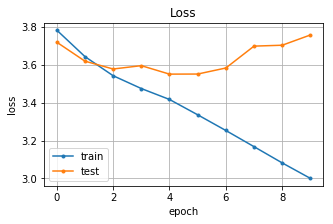

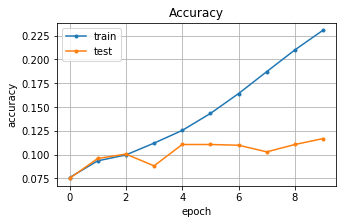

In [0]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='test')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['acc'], marker='.', label='train')
plt.plot(history.history['val_acc'], marker='.', label='test')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# Keras with GridSearchCV

In [0]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, 
                        weights = [embedding_matrix], 
                        trainable = False))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=100, verbose=0)

In [0]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1,verbose=True, return_train_score=True)
grid_result = grid.fit(x, y)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  8.4min finished


In [0]:
df = pd.DataFrame(grid_result.cv_results_)
df.to_csv('resultado_deep_learning_opinosis-parsed.csv')
print(df.to_csv())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,11.981858062744141,1.355458781389184,0.3017071485519409,0.10690485015423436,SGD,{'optimizer': 'SGD'},0.98039215378717,0.98039215378717,0.98039215378717,0.98039215378717,0.98039215378717,0.98039215378717,0.98039215378717,0.980392153873,0.980392153873,0.980392153873,0.9803921538128911,3.9320057043936274e-11,2,0.9803921579186343,0.9803921579186343,0.9803921579186343,0.9803921579186343,0.9803921579186343,0.9803921579186343,0.9803921579186343,0.9803921580314636,0.980

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980404 using {'optimizer': 'Adamax'}
0.980392 (0.000000) with: {'optimizer': 'SGD'}
0.979764 (0.000325) with: {'optimizer': 'RMSprop'}
0.979736 (0.000685) with: {'optimizer': 'Adagrad'}
0.980392 (0.000000) with: {'optimizer': 'Adadelta'}
0.980067 (0.000215) with: {'optimizer': 'Adam'}
0.980404 (0.000153) with: {'optimizer': 'Adamax'}
0.979147 (0.000516) with: {'optimizer': 'Nadam'}
